# Spectral analysis using background templates with Gammapy

This notebook is a prototype for a spectal analysis of an extended source using background templates.

## Setup

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from pathlib import Path

In [2]:
from gammapy.data import DataStore
from gammapy.utils.fitting import Fit
from gammapy.spectrum.models import ExponentialCutoffPowerLaw
from gammapy.spectrum import CountsSpectrum, SpectrumDataset
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.cube import MapMaker, MapDataset
from gammapy.cube.models import BackgroundModel
from gammapy.catalog import SourceCatalogHGPS
from gammapy.irf import EffectiveAreaTable
from gammapy.utils.fitting import Fit

In [3]:
HGPS_CATALOG = SourceCatalogHGPS()

# whether ro run data reduction
DATA_REDUCTION = False

## Data selection

In [4]:
data_store = DataStore.from_file(
    "$GAMMAPY_DATA/hess-dl3-dr1/hess-dl3-dr3-with-background.fits.gz"
)

# select target
mask = data_store.obs_table["TARGET_NAME"] == "RX J1713.7-3946"
obs_table = data_store.obs_table[mask]

# get observations
observations = data_store.get_observations(obs_table["OBS_ID"])

## Analysis setup

In [5]:
rxj_1713 = HGPS_CATALOG["RX J1713.7-3946"]

# energy binning
energy_axis = MapAxis.from_bounds(0.1, 30, nbin=30, unit="TeV", name="energy", interp="log")

# spatial binning
geom = WcsGeom.create(
    skydir=rxj_1713.position,
    axes=[energy_axis],
    binsz=0.02,
    width="5 deg",
    coordsys="GAL"
)

# analysis region for spectrum
region = CircleSkyRegion(center=rxj_1713.position, radius=0.5 * u.deg)

## Data reduction

We first run a 3D data reduction:

In [6]:
if DATA_REDUCTION:
    for obs in observations:
        map_maker = MapMaker(geom=geom, offset_max="2.5 deg")
        maps = map_maker.run([obs])

        path = Path("obs_{}".format(obs.obs_id))
        path.mkdir(exist_ok=True)
        
        offset = rxj_1713.position.separation(obs.pointing_radec)
        edisp = obs.edisp.to_energy_dispersion(offset=offset, e_true=energy_axis.edges, e_reco=energy_axis.edges)
        
        emin = edisp.get_bias_energy(0.1)
        
        dataset = MapDataset(
            counts=maps["counts"],
            background_model=BackgroundModel(maps["background"]),
            exposure=maps["exposure"],
            edisp=edisp,
            mask_safe=geom.energy_mask(emin=emin)
        )

        dataset.write(path / "map_dataset.fits.gz", overwrite=True)

This is a little helper function to reduce a 3D dataset to a spectral dataset. For this we sum the counts and background in the region of interest and average the exposure in the same region. 

In [7]:
def to_spectrum_dataset(obs, dataset, region):
    # reduce 3D maps to spectrum in a given region
    counts = dataset.counts.get_spectrum(region, func=np.nansum)
    background_map = dataset.background_model.evaluate()
    background = background_map.get_spectrum(region, func=np.nansum)
    exposure = dataset.exposure.get_spectrum(region, func=np.nanmean)
    
    livetime = obs.observation_live_time_duration
    
    edges = exposure.energy.edges
    data = exposure.quantity / livetime
    
    aeff = EffectiveAreaTable(
        energy_hi=edges[1:],
        energy_lo=edges[:-1],
        data=data
    )
    
    return SpectrumDataset(
        counts=counts,
        background=background,
        aeff=aeff,
        livetime=livetime,
        edisp=dataset.edisp,
        obs_id=obs.obs_id,
    )
    

## Background fitting and spectral data reduction

As a simple first step to improve the background model, we fit it outside the analysis region to the data. For this we allow the `norm` and `tilt` parameter to vary:

In [8]:
datasets = []

for obs in observations:
    dataset = MapDataset.read("obs_{}/map_dataset.fits.gz".format(obs.obs_id))
    
    # create fit mask 
    mask_fit = dataset.counts.geom.region_mask([region], inside=False)
    dataset.mask_fit = mask_fit
    dataset.background_model.tilt.frozen = False 
    
    # optimize background parameters
    fit = Fit(dataset)
    result = fit.optimize()
    
    # reduce map dataset to spectrum the analysis region
    spectrum_dataset = to_spectrum_dataset(obs, dataset, region)
    datasets.append(spectrum_dataset)

## Spectral model fitting

In [9]:
# spectral model from the 2016 analysis paper 
model = rxj_1713.spectral_model().copy()

# for now we choose a 1 TeV min energy threshold, because the background model
# is still very bad a low energies...
mask_fit = spectrum_dataset.counts.energy_mask(emin=1 * u.TeV)

# set model and enery threshold
for dataset in datasets:
    dataset.model = model
    dataset.mask_fit = mask_fit

In [10]:
fit = Fit(datasets)
result = fit.optimize()

In [11]:
print(result)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 80
	total stat : -2998.67



## Results

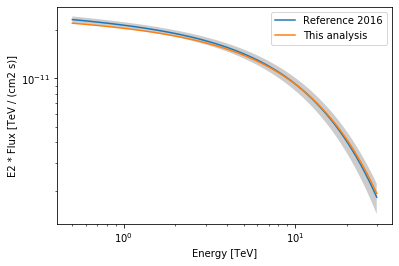

In [12]:
model_reference = rxj_1713.spectral_model()
energy_range = [0.5, 30] * u.TeV 

ax = model_reference.plot(energy_range=energy_range, energy_power=2, label="Reference 2016")
model_reference.plot_error(ax=ax, energy_range=energy_range, energy_power=2)

model.plot(ax=ax, energy_range=energy_range, energy_power=2, label="This analysis");
plt.legend()

In [13]:
print(dataset.model)

ExponentialCutoffPowerLaw

Parameters: 

	   name     value     error        unit      min max frozen
	--------- --------- --------- -------------- --- --- ------
	    index 2.051e+00 2.000e-02                nan nan  False
	amplitude 2.195e-11 1.000e-12 cm-2 s-1 TeV-1 nan nan  False
	reference 1.000e+00 0.000e+00            TeV nan nan   True
	  lambda_ 7.515e-02 6.610e-03          TeV-1 nan nan  False

Covariance: 

	   name     index   amplitude reference  lambda_ 
	--------- --------- --------- --------- ---------
	    index 4.000e-04 0.000e+00 0.000e+00 0.000e+00
	amplitude 0.000e+00 1.000e-24 0.000e+00 0.000e+00
	reference 0.000e+00 0.000e+00 0.000e+00 0.000e+00
	  lambda_ 0.000e+00 0.000e+00 0.000e+00 4.369e-05


In [14]:
print(model_reference)

ExponentialCutoffPowerLaw

Parameters: 

	   name     value     error        unit      min max frozen
	--------- --------- --------- -------------- --- --- ------
	    index 2.060e+00 2.000e-02                nan nan  False
	amplitude 2.300e-11 1.000e-12 cm-2 s-1 TeV-1 nan nan  False
	reference 1.000e+00 0.000e+00            TeV nan nan   True
	  lambda_ 7.752e-02 6.610e-03          TeV-1 nan nan  False

Covariance: 

	   name     index   amplitude reference  lambda_ 
	--------- --------- --------- --------- ---------
	    index 4.000e-04 0.000e+00 0.000e+00 0.000e+00
	amplitude 0.000e+00 1.000e-24 0.000e+00 0.000e+00
	reference 0.000e+00 0.000e+00 0.000e+00 0.000e+00
	  lambda_ 0.000e+00 0.000e+00 0.000e+00 4.369e-05
